In [1]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import *
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.stats import ttest_ind
import matplotlib

2024-07-01 09:57:46.789160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
rna_idx=pd.read_csv("../data/dataBulk/common_rna.csv",index_col=0).values.squeeze().tolist()

# prepare training data
files=["95233","26440","57065","4607","8121","9692","13904","26378","28750"]
data = []
label = []

for file in files:
    if file == "13904":
        df=pd.read_csv("../data/dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        df_label=pd.read_csv("../data/dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)
        x=df[rna_idx].T
        x=x[df_label[0]].T.values
        data.append(x)
        label.append(df_label[2].values>0)
    else:
        df=pd.read_csv("../data/dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        data.append(df[rna_idx].values)
        df_label=pd.read_csv("../data/dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)[2].values
        label.append(df_label>0)

In [4]:
for i,j in zip(data,label):
    print(i.shape,j.shape)

(124, 2869) (124,)
(130, 2869) (130,)
(107, 2869) (107,)
(123, 2869) (123,)
(75, 2869) (75,)
(45, 2869) (45,)
(70, 2869) (70,)
(103, 2869) (103,)
(30, 2869) (30,)


In [5]:
df_rna_idx = pd.Series(rna_idx)
df_rna_idx.name='gene'

dfseq1 = pd.read_csv('../data/dataBulk/RNAseq/tpm_185263.txt',sep = '\t')
dfseq1.index.name='gene'

dfseq1 = pd.merge(df_rna_idx, dfseq1, on='gene', how = 'left').fillna(0)
dfseq1 = dfseq1.drop(columns='gene').T
seq1 = dfseq1.values

seq1_label = pd.read_csv('../data/dataBulk/RNAseq/185263_label.txt').values.squeeze()
seq1_label.shape

(392,)

In [6]:
seq_train,seq_val, seqlabel_train,seqlabel_val = train_test_split(seq1,seq1_label,test_size=0.7,random_state=42)
print(seqlabel_train.shape,seqlabel_val.shape)

(117,) (275,)


In [7]:
print(sum(seqlabel_train))
print(sum(seqlabel_val))

103
245


In [8]:
def loadmodel():
    org_model = keras.models.load_model("../data/model/weightmodel")
    org_model = models.Model(inputs=org_model.input, outputs=org_model.get_layer('dense_6').output) # do not include final classifier
    return org_model

In [9]:
def transfer(org_model,sample,label):
    xtr,xval, ytr,yval = train_test_split(sample,label,test_size=0.2,random_state=42)
    cw = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(ytr),y=ytr)
    cw = {0:cw[0],1:cw[1]}
    
    org_model.trainable = False
    inputs = keras.Input(shape=(2869,1))
    x = org_model(inputs, training=False)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(xtr, ytr, batch_size=10, epochs=30, validation_data=(xval, yval),shuffle=True,class_weight=cw)

    org_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
    earlystopping = callbacks.EarlyStopping(monitor ="val_binary_accuracy", mode ="min", patience = 5, 
                                        restore_best_weights = True)
    model.fit(xtr, ytr, batch_size=10, epochs=30,validation_data=(xval, yval),
               shuffle=True,class_weight=cw)

    return model

In [12]:
# on other biomarkers
sota = pd.DataFrame(columns = ['Cohort','AUC','Model'])
results = []
for file in ["4607","8121","9692","13904","26378","28750"]:
    if file == "13904":
        df=pd.read_csv("../data/dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t")
        df_label=pd.read_csv("../data/dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)
        df=df[df_label[0]].T
        y_test=df_label[2].values>0
    else:
        df=pd.read_csv("../data/dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        df_label=pd.read_csv("../data/dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)[2].values
        y_test=(df_label>0)
    
    ratio = (-df['FAIM3']/df['PLAC8']).values
    SeptiCyte = ((df['PLAC8']/df['PLA2G7'])*(df['LAMP1']/df['CEACAM4'])).values
    sNIP = (-(df['NLRP1']-df['IDNK'])/df['PLAC8']).values
    
    for testresult,mod in zip([ratio,SeptiCyte,sNIP],['FAIM3/PLAC8','SeptiCyte','sNIP']):
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)
        sota = sota.append({'Cohort':'GSE'+file,'AUC':roc_auc,'Model':mod},ignore_index=True)
        results.append({'Cohort': 'GSE' + file, 'Model': mod, 'y_test': y_test, 'testresult': testresult})

# 将results转换为DataFrame并保存到csv文件中
results_df = pd.DataFrame(results)

In [13]:
results_df

,Cohort,Model,y_test,testresult
0,GSE4607,FAIM3/PLAC8,"[False, False, False, False, False, False, Fal...","[-0.8628010628267764, -0.8623511710630452, -0...."
1,GSE4607,SeptiCyte,"[False, False, False, False, False, False, Fal...","[3.00208210736278, 4.5526032780969174, 4.13347..."
2,GSE4607,sNIP,"[False, False, False, False, False, False, Fal...","[-0.021170823690751683, -0.026117358520103322,..."
3,GSE8121,FAIM3/PLAC8,"[False, False, False, False, False, False, Fal...","[-0.8231390897490429, -0.7861589161479311, -1...."
4,GSE8121,SeptiCyte,"[False, False, False, False, False, False, Fal...","[0.6242302767963537, 1.790176609556618, 1.4191..."
5,GSE8121,sNIP,"[False, False, False, False, False, False, Fal...","[0.08753721820501914, 0.0882460637129257, -0.0..."
6,GSE9692,FAIM3/PLAC8,"[True, True, True, True, True, True, True, Tru...","[-0.20415893056071294, -1.2643179451579312, -0..."
7,GSE9692,SeptiCyte,"[True, True, True, True, True, True, True, Tru...","[1.4684220779342412, 0.2046570448277876, 1.427..."
8,GSE9692,sNIP,"[True, True, True, True, True, True, True, Tru...","[0.1810620126253249, -0.9271086428323498, 0.78..."
9,GSE13904,FAIM3/PLAC8,"[False, False, False, False, False, False, Fal...","[-1.5915858489277421, -1.295240092262529, -1.0..."


In [45]:
results_df['y_test'] = results_df['y_test'].apply(lambda x: [int(item) for item in x])
results_df

,Cohort,Model,y_test,testresult
0,GSE4607,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8628010628267764, -0.8623511710630452, -0...."
1,GSE4607,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.00208210736278, 4.5526032780969174, 4.13347..."
2,GSE4607,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.021170823690751683, -0.026117358520103322,..."
3,GSE8121,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8231390897490429, -0.7861589161479311, -1...."
4,GSE8121,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6242302767963537, 1.790176609556618, 1.4191..."
5,GSE8121,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.08753721820501914, 0.0882460637129257, -0.0..."
6,GSE9692,FAIM3/PLAC8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.20415893056071294, -1.2643179451579312, -0..."
7,GSE9692,SeptiCyte,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.4684220779342412, 0.2046570448277876, 1.427..."
8,GSE9692,sNIP,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.1810620126253249, -0.9271086428323498, 0.78..."
9,GSE13904,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.5915858489277421, -1.295240092262529, -1.0..."


In [70]:
results_df['testresult'][0]

array([-0.86280106, -0.86235117, -0.9074936 , -0.88071205, -0.83070138,
       -0.9157019 , -0.83459677, -0.8088844 , -0.89821002, -0.85275195,
       -0.86873178, -0.89043958, -0.92899652, -0.92940808, -0.87857804,
       -0.56658252, -0.72547194, -0.53775563, -0.69672824, -0.7368588 ,
       -0.68851808, -0.71333426, -0.69185385, -0.66662709, -0.65461898,
       -0.65562624, -0.69202352, -0.70691869, -0.60643482, -0.68156941,
       -0.62203777, -0.79350165, -0.70679743, -0.81820144, -0.81425641,
       -0.7849025 , -0.7440218 , -0.83182489, -0.59165523, -0.65939277,
       -0.5923203 , -0.84165535, -0.66661529, -0.57908881, -0.62951351,
       -0.78475876, -0.82424134, -0.66370284, -0.62217654, -0.72499543,
       -0.72546771, -0.66904431, -0.62064474, -0.58750521, -0.72659205,
       -0.79052373, -0.70221318, -0.86934889, -0.56527164, -0.85988821,
       -0.90568175, -0.63646311, -0.76110211, -0.64881557, -0.74844549,
       -0.84719368, -0.73524661, -0.65851423, -0.73601308, -0.61

In [69]:
def clean_array(arr):
    return np.array(arr)

results_df['testresult'] = results_df['testresult'].apply(clean_array)
results_df

,Cohort,Model,y_test,testresult
0,GSE4607,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8628010628267764, -0.8623511710630452, -0...."
1,GSE4607,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.00208210736278, 4.5526032780969174, 4.13347..."
2,GSE4607,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.021170823690751683, -0.026117358520103322,..."
3,GSE8121,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8231390897490429, -0.7861589161479311, -1...."
4,GSE8121,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6242302767963537, 1.790176609556618, 1.4191..."
5,GSE8121,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.08753721820501914, 0.0882460637129257, -0.0..."
6,GSE9692,FAIM3/PLAC8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.20415893056071294, -1.2643179451579312, -0..."
7,GSE9692,SeptiCyte,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.4684220779342412, 0.2046570448277876, 1.427..."
8,GSE9692,sNIP,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.1810620126253249, -0.9271086428323498, 0.78..."
9,GSE13904,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.5915858489277421, -1.295240092262529, -1.0..."


In [14]:
sota2 = pd.DataFrame(columns = ['Cohort','AUC','Model'])
results2 = []
df1 = pd.read_csv('../data/dataBulk/RNAseq/tpm_185263.txt',sep = '\t').T

for df,y_test,file in zip([df1],[seq1_label],['185263']):
    ratio = (-np.log2(df['FCMR'])/np.log2(df['PLAC8'])).values
    SeptiCyte = ((df['PLAC8']/df['PLA2G7'])*(df['LAMP1']/df['CEACAM4'])).values
    sNIP = (-(df['NLRP1']-df['IDNK'])/df['PLAC8']).values
    
    SeptiCyte[np.isinf(SeptiCyte)]=100000 #replace infinity
    
    for testresult,mod in zip([ratio,SeptiCyte,sNIP],['FAIM3/PLAC8','SeptiCyte','sNIP']):
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)

        sota2 = sota2.append({'Cohort':'GSE'+file,'AUC':roc_auc,'Model':mod},ignore_index=True)
        results2.append({'Cohort': 'GSE' + file, 'Model': mod, 'y_test': y_test, 'testresult': testresult})
results_df2 = pd.DataFrame(results2)

In [20]:
sota2

,Cohort,AUC,Model
0,GSE185263,0.952913,FAIM3/PLAC8
1,GSE185263,0.669148,SeptiCyte
2,GSE185263,0.877939,sNIP


In [15]:
results_df2

,Cohort,Model,y_test,testresult
0,GSE185263,FAIM3/PLAC8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.7990378434993861, -0.8241036964170788, -0...."
1,GSE185263,SeptiCyte,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[14.901159286791897, 20.91584629959247, 31.555..."
2,GSE185263,sNIP,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.2790699577215066, -0.12819289179843396, -0..."


In [46]:
##biomarker的方法都和到一起，
biomarker_df =  pd.concat([results_df,results_df2],ignore_index=True)
biomarker_df                           

,Cohort,Model,y_test,testresult
0,GSE4607,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8628010628267764, -0.8623511710630452, -0...."
1,GSE4607,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.00208210736278, 4.5526032780969174, 4.13347..."
2,GSE4607,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.021170823690751683, -0.026117358520103322,..."
3,GSE8121,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8231390897490429, -0.7861589161479311, -1...."
4,GSE8121,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6242302767963537, 1.790176609556618, 1.4191..."
5,GSE8121,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.08753721820501914, 0.0882460637129257, -0.0..."
6,GSE9692,FAIM3/PLAC8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.20415893056071294, -1.2643179451579312, -0..."
7,GSE9692,SeptiCyte,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.4684220779342412, 0.2046570448277876, 1.427..."
8,GSE9692,sNIP,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.1810620126253249, -0.9271086428323498, 0.78..."
9,GSE13904,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.5915858489277421, -1.295240092262529, -1.0..."


In [12]:
def drawsota(roc1,file_train):
    cohorts = roc1['Cohort'].unique().tolist()
    model_names = roc1['Model'].unique().tolist()

    model_aucs = []
    for model in model_names:
        model_aucs.append(roc1[roc1['Model']==model]['AUC'].tolist())

    num_models = len(model_names)

    shift = num_models // 2 # the middle point to shift

    x = np.arange(len(cohorts))*2  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,6))

    model_axs = []
    for i in range(num_models):
        model_axs.append(ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUROC Score',size = 20)
    ax.set_title('AUROC on microarray compared with biomarkers',size=20)
    ax.set_ylim(ymin=0.4,ymax=1.1)
    ax.set_xticks(x, cohorts)
    ax.legend()

    for model_ax in model_axs:
        ax.bar_label(model_ax, padding=-45, fmt='%.3f', rotation='vertical',size=15)

    plt.legend(loc='lower right',prop={'size':15})

    fig.tight_layout()

    plt.savefig('./'+file_train+'sota0606.png',dpi=100)

    plt.show()

In [20]:
colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D',
         '#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F']
names = ["K-Nearest Neighbors", "DecisionTree",
         "Random Forest", "Naive Bayes", "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=7),
    RandomForestClassifier(random_state=7),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [14]:
def drawML(roc2,file_train):
    cohorts = roc2['Cohort'].unique().tolist()
    model_names = roc2['Model'].unique().tolist()

    model_aucs = []
    for model in model_names:
        model_aucs.append(roc2[roc2['Model']==model]['AUC'].tolist())

    num_models = len(model_names)

    shift = num_models // 2 # the middle point to shift

    x = np.arange(len(cohorts))*4  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,5))

    model_axs = []
    colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D','#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F']

    for i in range(num_models):
        model_axs.append(ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUROC Score',size=15)
    ax.set_title('AUROC on microarray data',size=15)
    ax.set_xticks(x, cohorts,fontsize=14)
    ax.set_ylim(ymin=0.3,ymax=1.1)
    ax.legend()

    for model_ax in model_axs:
        ax.bar_label(model_ax, padding=-40, fmt='%.3f', rotation='vertical', size=13)

    plt.legend(loc='lower left',bbox_to_anchor = (0,-0.3), ncol=5,prop={'size':13})

    fig.tight_layout()
    plt.savefig('./'+file_train+'ML0613.png',dpi=100)

    plt.show()

In [62]:
x_train = np.append(np.append(data[0], data[1], axis=0),data[2], axis=0)
y_train = np.append(np.append(label[0],label[1], axis=0),label[2], axis=0)
file_train = ["95233","26440","57065"]
save_name = "95233+26440+57065"
results_cat = []
org_model = loadmodel()
model = transfer(org_model,x_train,y_train)
# model = keras.models.load_model("./model/transferred_model")
results = pd.DataFrame(columns = ['Cohort','AUC','Model'])

# test CapTrans
for x_test,y_test,file_test in zip(data[3:],label[3:],files[3:]):
        testresult=model.predict(x_test)
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)
        print(roc_auc)
        results = results.append({'Cohort':'GSE'+file_test,'AUC':roc_auc,'Model':'CaT'},ignore_index=True)
        results_cat.append({'Cohort': 'GSE' + file_test, 'Model': 'CaT', 'y_test': y_test, 'testresult': testresult})

results_CaT = pd.DataFrame(results_cat)

Epoch 1/30
29/29 [==============================] - 3s 35ms/step - loss: 0.6677 - accuracy: 0.6146 - val_loss: 0.5786 - val_accuracy: 0.7808
Epoch 2/30
29/29 [==============================] - 1s 23ms/step - loss: 0.6180 - accuracy: 0.8221 - val_loss: 0.6732 - val_accuracy: 0.5342
Epoch 3/30
29/29 [==============================] - 1s 23ms/step - loss: 0.6724 - accuracy: 0.3997 - val_loss: 0.5418 - val_accuracy: 0.7808
Epoch 4/30
29/29 [==============================] - 1s 23ms/step - loss: 0.6335 - accuracy: 0.7739 - val_loss: 0.6623 - val_accuracy: 0.5753
Epoch 5/30
29/29 [==============================] - 1s 23ms/step - loss: 0.6329 - accuracy: 0.6680 - val_loss: 0.5708 - val_accuracy: 0.9726
Epoch 6/30
29/29 [==============================] - 1s 23ms/step - loss: 0.5983 - accuracy: 0.8651 - val_loss: 0.5608 - val_accuracy: 0.9726
Epoch 7/30
29/29 [==============================] - 1s 23ms/step - loss: 0.6084 - accuracy: 0.9146 - val_loss: 0.5585 - val_accuracy: 1.0000
Epoch 8/30
29

In [63]:
results_CaT['y_test'] = results_CaT['y_test'].apply(lambda x: [int(item) for item in x])
results_CaT['testresult'] = results_CaT['testresult'].apply(lambda x: [item for sublist in x for item in sublist])
results_CaT

,Cohort,Model,y_test,testresult
0,GSE4607,CaT,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.016467458, 0.00610318, 0.017789328, 0.00880..."
1,GSE8121,CaT,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.027734289, 0.026934873, 0.027492005, 0.0280..."
2,GSE9692,CaT,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.12570997, 0.06175387, 0.9999795, 0.9720444,..."
3,GSE13904,CaT,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02897917, 0.03248768, 0.022747518, 0.032969..."
4,GSE26378,CaT,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0.9984535, 0.9901484, 0.99950695, 0.98993987,..."
5,GSE28750,CaT,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0.9786122, 0.97637355, 0.99970067, 0.9998741,..."


In [30]:
# compare to SOTA
results = pd.concat([results,sota],ignore_index=True)
results = pd.concat([results,sota2],ignore_index=True)
results

,Cohort,AUC,Model
0,GSE4607,0.988889,CaT
1,GSE8121,0.988889,CaT
2,GSE9692,1.000000,CaT
3,GSE13904,0.964744,CaT
4,GSE26378,0.997677,CaT
5,GSE28750,1.000000,CaT
6,GSE4607,0.886420,FAIM3/PLAC8
7,GSE4607,0.617284,SeptiCyte
8,GSE4607,0.885802,sNIP
9,GSE8121,0.907778,FAIM3/PLAC8


In [51]:
# compare to other ML
results_ml = []
for name,clf_ in zip(names,classifiers):
        clf_.fit(x_train, y_train)
        for x_test,y_test,file_test in zip(data[3:],label[3:],files[3:]):
            predt = clf_.predict(x_test)
            fpr, tpr, _ = roc_curve(y_test,predt)
            roc_auc = auc(fpr,tpr)
            results = results.append({'Cohort':'GSE'+file_test,'AUC':roc_auc,'Model':name},ignore_index=True)
            results_ml.append({'Cohort': 'GSE' + file_test, 'Model': name, 'y_test': y_test, 'testresult': predt})
results_ML = pd.DataFrame(results_ml)

/home/dm/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [53]:
results_ML['y_test'] = results_ML['y_test'].apply(lambda x: [int(item) for item in x])
results_ML['testresult'] = results_ML['testresult'].apply(lambda x: [int(item) for item in x])
results_ML

,Cohort,Model,y_test,testresult
0,GSE4607,K-Nearest Neighbors,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,GSE8121,K-Nearest Neighbors,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,GSE9692,K-Nearest Neighbors,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,GSE13904,K-Nearest Neighbors,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,GSE26378,K-Nearest Neighbors,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, ..."
5,GSE28750,K-Nearest Neighbors,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
6,GSE4607,DecisionTree,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,GSE8121,DecisionTree,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,GSE9692,DecisionTree,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,GSE13904,DecisionTree,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
results_cat1 = []
            
seq_train,seq_val, seqlabel_train,seqlabel_val = train_test_split(seq1,seq1_label,test_size=0.7,random_state=42)
file_train = ["185263"]
save_name = "185263"

org_model = loadmodel()
model = transfer(org_model,seq_train,seqlabel_train)
# model = keras.models.load_model("./model/transferred_model")

# test CapTrans
testresult=model.predict(seq_val)
fpr, tpr, _ = roc_curve(seqlabel_val,testresult)
roc_auc = auc(fpr,tpr)
print(roc_auc)
results = results.append({'Cohort':'GSE'+'185263','AUC':roc_auc,'Model':'CaT'},ignore_index=True)
results_cat1.append({'Cohort': 'GSE' + '185263', 'Model': 'CaT', 'y_test': seqlabel_val, 'testresult': testresult})
results_CaT1 = pd.DataFrame(results_cat1)

Epoch 1/30
10/10 [==============================] - 2s 65ms/step - loss: 0.8107 - accuracy: 0.0756 - val_loss: 0.7635 - val_accuracy: 0.3750
Epoch 2/30
10/10 [==============================] - 0s 27ms/step - loss: 0.6771 - accuracy: 0.4114 - val_loss: 0.6306 - val_accuracy: 0.7500
Epoch 3/30
10/10 [==============================] - 0s 27ms/step - loss: 0.6223 - accuracy: 0.6828 - val_loss: 0.6705 - val_accuracy: 0.5417
Epoch 4/30
10/10 [==============================] - 0s 27ms/step - loss: 0.8068 - accuracy: 0.3540 - val_loss: 0.7686 - val_accuracy: 0.3750
Epoch 5/30
10/10 [==============================] - 0s 27ms/step - loss: 0.6311 - accuracy: 0.3127 - val_loss: 0.6470 - val_accuracy: 0.6250
Epoch 6/30
10/10 [==============================] - 0s 27ms/step - loss: 0.6310 - accuracy: 0.7284 - val_loss: 0.6210 - val_accuracy: 0.7500
Epoch 7/30
10/10 [==============================] - 0s 27ms/step - loss: 0.7024 - accuracy: 0.5713 - val_loss: 0.7078 - val_accuracy: 0.5000
Epoch 8/30
10

In [58]:
results_CaT1

,Cohort,Model,y_test,testresult
0,GSE185263,CaT,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[[0.87594706], [0.22732697], [0.70470345], [0...."


In [59]:
results_CaT1.at[0, 'testresult'] = [item for sublist in results_CaT1.at[0, 'testresult'] for item in sublist]
results_CaT1

,Cohort,Model,y_test,testresult
0,GSE185263,CaT,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[0.87594706, 0.22732697, 0.70470345, 0.7983318..."


In [30]:
results_ml1 = []
for name,clf_ in zip(names,classifiers):
        clf_.fit(seq_train, seqlabel_train)
        
        predt = clf_.predict(seq_val)
        fpr, tpr, _ = roc_curve(seqlabel_val,predt)
        roc_auc = auc(fpr,tpr)
        results = results.append({'Cohort':'GSE'+'185263','AUC':roc_auc,'Model':name},ignore_index=True)
        results_ml1.append({'Cohort': 'GSE' + '185263', 'Model': name, 'y_test': seqlabel_val, 'testresult': predt})
results_ML1 = pd.DataFrame(results_ml1)        

/home/dm/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [31]:
results_ML1

,Cohort,Model,y_test,testresult
0,GSE185263,K-Nearest Neighbors,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
1,GSE185263,DecisionTree,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
2,GSE185263,Random Forest,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
3,GSE185263,Naive Bayes,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
4,GSE185263,Quadratic Discriminant Analysis,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [64]:
Finalresults = pd.concat([biomarker_df,results_CaT,results_ML ,results_CaT1,results_ML1],ignore_index=True)
Finalresults

,Cohort,Model,y_test,testresult
0,GSE4607,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8628010628267764, -0.8623511710630452, -0...."
1,GSE4607,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.00208210736278, 4.5526032780969174, 4.13347..."
2,GSE4607,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.021170823690751683, -0.026117358520103322,..."
3,GSE8121,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8231390897490429, -0.7861589161479311, -1...."
4,GSE8121,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6242302767963537, 1.790176609556618, 1.4191..."
...,...,...,...,...
58,GSE185263,K-Nearest Neighbors,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
59,GSE185263,DecisionTree,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
60,GSE185263,Random Forest,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
61,GSE185263,Naive Bayes,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."


In [65]:
Finalresults.to_csv('../data/prep_plot_transferresults_rocprc.csv',index=None)

In [57]:
Finalresults['y_test1'] = Finalresults['y_test'].apply(lambda x: str(x))
Finalresults['testresult1'] = Finalresults['testresult'].apply(lambda x: str(x))
Finalresults

,Cohort,Model,y_test,testresult,y_test1,testresult1
0,GSE4607,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8628010628267764, -0.8623511710630452, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.86280106 -0.86235117 -0.9074936 -0.880712...
1,GSE4607,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.00208210736278, 4.5526032780969174, 4.13347...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[3.00208211 4.55260328 4.13347301 3.96473621 3...
2,GSE4607,sNIP,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.021170823690751683, -0.026117358520103322,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.02117082 -0.02611736 -0.06630476 -0.040100...
3,GSE8121,FAIM3/PLAC8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8231390897490429, -0.7861589161479311, -1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.82313909 -0.78615892 -1.2177 -1.072081...
4,GSE8121,SeptiCyte,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6242302767963537, 1.790176609556618, 1.4191...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0.62423028 1.79017661 1.41918019 1.45863982 1...
...,...,...,...,...,...,...
58,GSE185263,K-Nearest Neighbors,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...",[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1...,[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1...
59,GSE185263,DecisionTree,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...",[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1...,[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1...
60,GSE185263,Random Forest,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...",[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1...,[1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1...
61,GSE185263,Naive Bayes,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...",[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1...,[1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1...


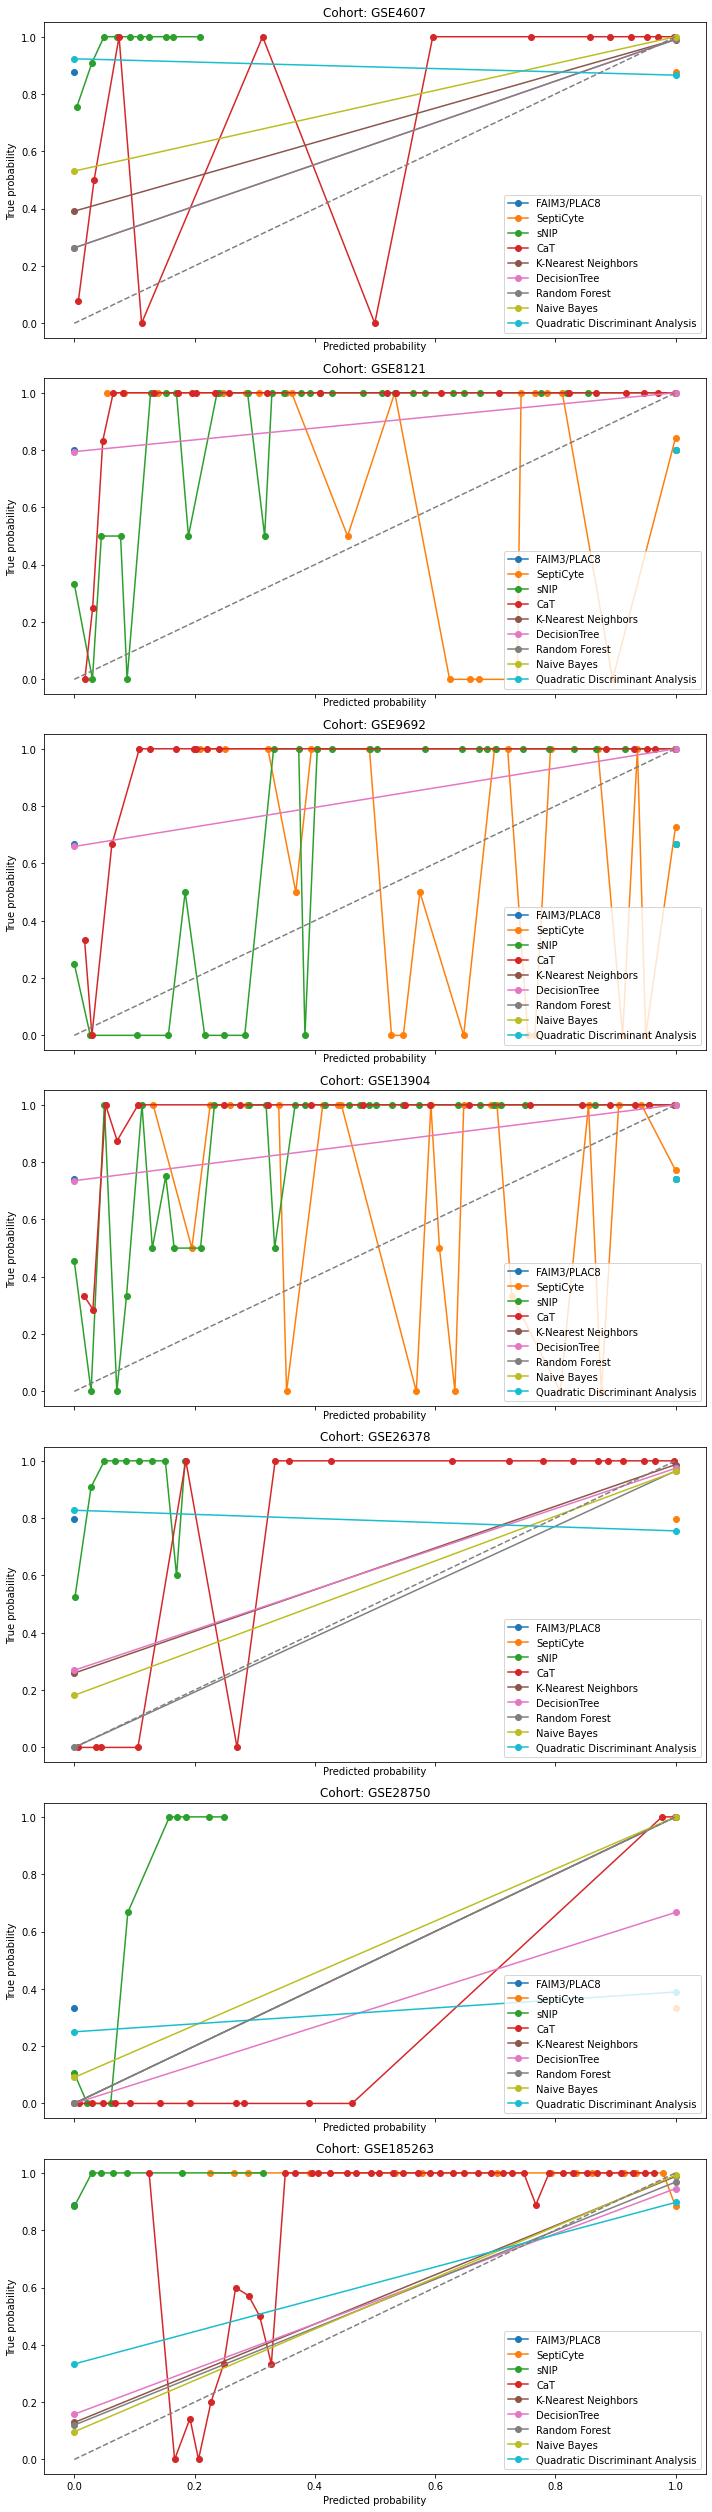

In [95]:
#######calibration plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Custom converter function to parse the array strings
def parse_array(array_str):
    array_str = array_str.strip('[]')
    # Split by commas or spaces and filter out any empty strings
    return np.array([float(x) for x in array_str.replace(',', ' ').split() if x])

# Load the CSV file
file_path = './prep_plot_transferresults_rocprc.csv'
df = pd.read_csv(file_path, converters={'y_test': parse_array, 'testresult': parse_array})

# Get the unique cohorts
cohorts = df['Cohort'].unique()
models = df['Model'].unique()

# Plot calibration plots by cohort
fig, axes = plt.subplots(len(cohorts), 1, figsize=(10, 5 * len(cohorts)), sharex=True, sharey=True)
colors = plt.cm.get_cmap('tab10', len(models))

for idx, cohort in enumerate(cohorts):
    ax = axes[idx]
    cohort_data = df[df['Cohort'] == cohort]
    ax.set_title(f'Cohort: {cohort}')
    
    for model_idx, model in enumerate(models):
        model_data = cohort_data[cohort_data['Model'] == model]
        if not model_data.empty:
            true_labels = np.concatenate(model_data['y_test'].values)
            pred_labels = np.concatenate(model_data['testresult'].values)
            
            # Normalize the predicted labels to be within [0, 1]
            pred_labels = np.clip(pred_labels, 0, 1)
            
            prob_true, prob_pred = calibration_curve(true_labels, pred_labels, n_bins=50)
            ax.plot(prob_pred, prob_true, marker='o', label=model, color=colors(model_idx))
    
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
